# Supercharging customer touchpoints with uplift modeling

Stephen Klosterman

7/8/2020

<img src="images/space-shuttle-774_1280.jpg" alt="Lift off, from https://pixabay.com/photos/space-shuttle-rocket-lift-off-774/" style="width: 400px;"/>

Image from [Pixabay](https://pixabay.com/photos/space-shuttle-rocket-lift-off-774/)

In this post I will introduce the concept of uplift modeling and make a case for why it's an important part of the data scientist's toolbox of methods to increase business value. Then I'll show a simple way to build an uplift model and demonstrate a few uplift model evaluation metrics, using synthetic data in Python.

- [Introduction](#Intro)
- [Data for uplift modeling: experiments are key](#Experiments)
- [Mechanics of the model](#Mechanics)
- [Example dataset](#Example)
- [Analyze experimental results](#Analyze)
- [Build an uplift model](#Build)
- [Model evaluation](#Model-evaluation)
    - [Quantile metrics](#quantile-metrics)
        - [Get score quantiles](#get-quantiles)
        - [Uplift quantile chart](#quantile-chart)
        - [Calibration of uplift](#calibration)
    - [Cumulative metrics](#cumulative-metrics)
        - [Cumulative gain chart](#Cumulative-gain)
        - [Cumulative gain curve](#gain-curve)
- [Conclusion](#conclusion)
- [References](#references)

# Introduction <a class="anchor" id="Intro"></a>

Of the myriad ways that machine learning can create value for businesses, uplift modeling is one of the lesser known, compared to methods such as supervised classification or regression. But for many use cases, it may be the most effective modeling technique. In any situation where there is a costly action a business can selectively take for different customers, in hopes of influencing their behavior, uplift modeling should be a strong candidate for determining strategy. This is because uplift modeling aims to find the subset of customers that would be most influenced by the action. Identifying this segment is important for maximizing the return on investment in a business strategy.

For example, in offering a coupon, a business is taking a potential revenue hit: if a customer buys and uses the coupon, revenue will be decreased by the value of the coupon. But, if the coupon persuades the customer to make a purchase, when they otherwise wouldn’t have, then it may still be worth it. These kinds of customers are called “persuadables” in the terminology of uplift modeling, which breaks things down into customer behavior with and without “treatment”, where treatment in this example is receiving a coupon.

<img src="https://storage.googleapis.com/wf-blogs-engineering-media/2018/10/e45e2d97-confmatrix_alt.png" alt="Drawing" style="width: 400px;"/>

Image from Yi and Frost (2018)

The goal of uplift modeling, also known as net lift or incremental response modeling, is to identify the "persuadables", not waste efforts on "sure things" and "lost causes", and avoid bothering "sleeping dogs", or those who would react negatively to the treatment, if they exist. Uplift modeling has found application in many domains including marketing, the classic use case illustrated here, as well as <a href="https://blogs.oracle.com/datascience/data-driven-debt-collection-using-machine-learning-and-predictive-analytics" target="_blank">debt collection</a> and <a href="https://go.forrester.com/blogs/13-06-27-how_the_obama_campaign_used_predictive_analytics_to_influence_voters/" target="_blank">political campaigns</a>.

# Data for uplift modeling: experiments are key <a class="anchor" id="Experiments"></a>
Now that we know the goal of uplift modeling, how do we get there? A typical starting point for building an uplift model is a dataset from a randomized, controlled experiment: we need a representative sample of all different kinds of customers in both a treatment group, as well as a control group that didn't receive treatment. If the proportion of customers making a purchase is significantly higher in the treatment group than the control group, we know that the promotion is “working” in the sense that it encourages a purchase on average across all customers. This is called the average treatment effect (ATE). Quantifying the ATE is the typical outcome of an A/B test.

However, it may be that only a portion of customers within the treatment group are responsible for most of the ATE we observe. As an extreme example, maybe half of the customers in the treatment group were responsible for the entire ATE, whereas the promotion had no effect on the other half. If we had some way to identify the persuadable segment of customers ahead of time, who would more readily respond to treatment, then we would be able to concentrate our resources on them, and not waste time on those for whom the treatment would have little or no effect. We may need to find other promotions to engage the non-responders. In the process of determining variable treatment effects from person to person, conditional on the different traits these people have, we’re looking for the individual treatment effect (ITE), also called the conditional average treatment effect (CATE). This is where machine learning and predictive modeling come into the picture.

# Mechanics of the model <a class="anchor" id="Mechanics"></a>
A classic technique for structuring an uplift model is to predict, for an individual customer, their likelihood of purchase if they are treated, and also the likelihood if they are not treated. These two probabilities are then subtracted to obtain the uplift: how much more likely is a purchase if treatment is given? This can be accomplished in two ways, where in both cases the binary response variable of the model is whether or not the customer made a purchase after the treatment:
- Lumping the treatment and control groups together into one data set and training a single model where treatment is a binary feature. In the inference phase, the model is used to make two predictions for each instance, the first with treatment = 1 and the second with treatment = 0. This is called the "S-Learner" approach since it uses a Single model.
- Training separate models for the treatment and control groups. In the inference phase, the treatment and control models are both used to obtain predictions for each instance. This is called the "T-Learner" approach since it uses Two models.

The two approaches are summarized in the following schematic:

<img src="images/s-t-learner.svg" alt="S- and T-Learner differences" style="width: 800px;"/>

These approaches are widely documented in the literature on uplift modeling and causal inference (Lee et al. 2013, Gutierrez and Gerardy 2016). They have the advantage of being relatively simple and intuitive, and can be implemented using binary classification modeling techniques that many data scientists are familiar with, as well as specialized packages in enterprise software such as SAS (Lee et al. 2013). At the same time, causal inference is an active area of research within machine learning and other approaches may achieve better model performance. Different approaches include tree-based models designed to target uplift (reviewed in Gutierrez and Gerardy 2016), target variable transformation (Yi and Frost 2018), and other more recent innovations such as the X-Learner (Kunzel et al. 2019).

In all varieties, uplift modeling faces a fundamental challenge. The goal is to predict, for an individual customer, their likelihood of purchase if treated, and also the likelihood if not treated, to calculate the uplift. But in reality, we never observe the outcome for someone who was both treated and not treated, because this is impossible! Someone is either treated, or not. In mathematical modeling, it’s typically a problem if we can’t observe all the outcomes we’re interested in. This challenge illustrates the counterfactual nature of uplift modeling, and the importance of randomized experiments to understand the CATE across all types of customers.

<img src="images/fork-2115485_960_720.jpg" alt="The choice of treating or not treating, from https://pixabay.com/images/id-2115485/" style="width: 400px;"/>

Image from [Pixabay](https://pixabay.com/images/id-2115485/)

Gutierrez and Gerardy (2016) summarize this challenge and point the way forward:

>Estimating customer uplift is both a Causal Inference and a Machine Learning problem. It is a causal inference problem because one needs to estimate the difference between two outcomes that are mutually exclusive for an individual (either person *i* receives a promotional e-mail or does not receive it). To overcome this counter-factual nature, uplift modeling crucially relies on randomized experiments, i.e. the random assignment of customers to either receive the treatment (the treatment group) or not (the control group). Uplift modeling is also a machine learning problem as one needs to train different models and select the one that yields the most reliable uplift prediction according to some performance metrics. This requires sensible cross-validation strategies along with potential feature engineering.

Let's explore these concepts using an example dataset, by building an S-Learner model and evaluating it.

In [1]:
# load packages
import numpy as np
import pandas as pd

from statsmodels.stats.proportion import proportions_ztest

import sklearn as sk
from sklearn.metrics import auc
import xgboost as xgb

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

# Example dataset <a class="anchor" id="Example"></a>
The most straightforward way to build an uplift model is to start with data from a randomized controlled experiment. This way, both the treatment and control groups should have a representative sample of the population of customers. Outside of designed experiments, quasi-experimental data may be available if a natural control group exists as part of a business's normal operations. Treatment and control groups can also be approximated by a technique known as propensity score matching, available in the CausalML package that also offers a suite of uplift modeling tools (CausalML).

Here we use synthetic data from a recent publication (Zhao et al. 2020), which are publicly available [here](https://zenodo.org/record/3653141#.XwEVz5NKjYU). These data simulate a designed experiment with an even split between treatment and control groups. We load only the first 10,000 rows from this dataset, which is the first of "100 trials (replicates with different random seeds)". The dataset is constructed so that some features are predictive of the outcome, some are uninformative, and some are predictive of the treatment effect specifically.

The columns we're interested in are `treatment_group_key`, which identifies whether or not the customer received treatment, `conversion` which is 1 if the customer made a purchase and 0 if not, and the 36 synthetic features which all start with `x`. In real data, the features may correspond to such things as customer purchase history, demographics, and other quantities a data scientist may engineer with the hypothesis that they would be useful in modeling uplift.

Let's load the data and briefly explore it.

In [2]:
df = pd.read_csv('data/uplift_synthetic_data_100trials.csv', nrows=10000)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 43 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  10000 non-null  int64  
 1   trial_id                    10000 non-null  int64  
 2   treatment_group_key         10000 non-null  object 
 3   conversion                  10000 non-null  int64  
 4   control_conversion_prob     10000 non-null  float64
 5   treatment1_conversion_prob  10000 non-null  float64
 6   treatment1_true_effect      10000 non-null  float64
 7   x1_informative              10000 non-null  float64
 8   x2_informative              10000 non-null  float64
 9   x3_informative              10000 non-null  float64
 10  x4_informative              10000 non-null  float64
 11  x5_informative              10000 non-null  float64
 12  x6_informative              10000 non-null  float64
 13  x7_informative              1000

In [4]:
df.head()

,Unnamed: 0,trial_id,treatment_group_key,conversion,control_conversion_prob,treatment1_conversion_prob,treatment1_true_effect,x1_informative,x2_informative,x3_informative,...,x27_irrelevant,x28_irrelevant,x29_irrelevant,x30_irrelevant,x31_uplift_increase,x32_uplift_increase,x33_uplift_increase,x34_uplift_increase,x35_uplift_increase,x36_uplift_increase
0,0,0,control,1,0.516606,0.572609,0.056002,-1.926651,1.233472,-0.475120,...,-0.378145,-0.110782,1.087180,-1.222069,-0.279009,1.013911,-0.570859,-1.158216,-1.336279,-0.708056
1,1,0,treatment1,1,0.304005,0.736460,0.432454,0.904364,0.868705,-0.285977,...,-0.742847,0.700239,0.001867,-0.069362,0.045789,1.364182,-0.261643,0.478074,0.531477,0.402723
2,2,0,treatment1,0,0.134277,0.480985,0.346709,1.680978,1.320889,0.059273,...,0.748884,-0.856898,-0.268034,-2.181874,1.473214,-1.256641,0.901139,2.029204,-0.280445,0.873970
3,3,0,treatment1,1,0.801968,0.858532,0.056563,-0.335774,-2.940232,-0.302521,...,0.151074,0.067547,-0.839246,0.587575,0.412081,0.141189,0.369611,-0.364984,-1.509045,-1.335023
4,4,0,control,0,0.063552,0.060142,-0.003410,-0.475881,-0.485793,0.978582,...,-1.287117,1.256396,-1.155307,-0.414787,1.163851,0.698114,0.088157,0.478717,-0.680588,-2.730850


Of these 10,000 records, how many are in the treatment group, and how many are in the control group?

In [5]:
df['treatment_group_key'].value_counts()

control       5000
treatment1    5000
Name: treatment_group_key, dtype: int64

There is a 50/50 split. Let's encode the treatment variable as a binary 0/1:

In [6]:
df['treatment_group_key'] = df['treatment_group_key'].map(arg={'control':0, 'treatment1':1})

# Analyze experimental results <a class="anchor" id="Analyze"></a>

What was the overall conversion rate?

In [7]:
df['conversion'].mean()

0.3191

What's the conversion rate in the treatment group versus the control group?

In [8]:
exp_results_df = \
df.groupby('treatment_group_key').agg({'conversion':['mean', 'sum', 'count']})
exp_results_df

conversion            
                          mean   sum count
treatment_group_key                       
0                       0.2670  1335  5000
1                       0.3712  1856  5000

In [9]:
(exp_results_df.loc[1,('conversion', 'mean')]
 - exp_results_df.loc[0,('conversion', 'mean')]).round(4)

0.1042

There is a substantially higher conversion rate in the treatment group (37%) than the control group (27%), indicating the treatment is effective at encouraging conversion: the ATE is positive and is about 10%.

Often in real data the difference is not so large and a significance test is usually conducted to determine the result of the A/B test.

In [10]:
proportions_ztest(count=exp_results_df[('conversion', 'sum')],
                  nobs=exp_results_df[('conversion', 'count')])

(-11.177190529878043, 5.273302441543889e-29)

The p-value is the second quantity returned from the proportion test and is much smaller than 0.05, or pretty much any other threshold used to decide significance. So we know there's a significant ATE. This is the typical starting point for uplift modeling. If we were to have observed that the treatment did not increase conversion rate, while theoretically it may be possible to find a persuadable segment of customers using uplift modeling, in practice it may not be a worthwhile endeavor. This likely depends on the specific problem at hand.

However in our case, having observed a substantial treatment effect, we proceed to use uplift modeling to find the CATE, and see if we can identify those persuadables.

# Build an uplift model <a class="anchor" id="Build"></a>
Here I'll use an `XGBClassifier` to train an S-Learner; that is, a single model including all the features, where the treatment indicator is also a feature. I'll split the data into training and validation sets (80/20 split), for early stopping. I'll also use the validation set to illustrate model evaluation metrics. In a real project, a held out test set should be reserved from this process, where the evaluation metrics on the test set would be used for final evaluation of the model.

In [11]:
train, valid = sk.model_selection.train_test_split(df, test_size=0.2,random_state=42)

In [12]:
print(train.shape, valid.shape)

(8000, 43) (2000, 43)


Specify the features as a list. This includes the treatment column and all features, which are the 8th column onward:

In [13]:
features = ['treatment_group_key'] + df.columns.tolist()[7:]

In [14]:
print(features)

['treatment_group_key', 'x1_informative', 'x2_informative', 'x3_informative', 'x4_informative', 'x5_informative', 'x6_informative', 'x7_informative', 'x8_informative', 'x9_informative', 'x10_informative', 'x11_irrelevant', 'x12_irrelevant', 'x13_irrelevant', 'x14_irrelevant', 'x15_irrelevant', 'x16_irrelevant', 'x17_irrelevant', 'x18_irrelevant', 'x19_irrelevant', 'x20_irrelevant', 'x21_irrelevant', 'x22_irrelevant', 'x23_irrelevant', 'x24_irrelevant', 'x25_irrelevant', 'x26_irrelevant', 'x27_irrelevant', 'x28_irrelevant', 'x29_irrelevant', 'x30_irrelevant', 'x31_uplift_increase', 'x32_uplift_increase', 'x33_uplift_increase', 'x34_uplift_increase', 'x35_uplift_increase', 'x36_uplift_increase']


Assemble the training and validation sets for training the XGBoost classifer:

In [15]:
X_train = train[features]
y_train = train['conversion']
X_valid = valid[features]
y_valid = valid['conversion']

In [16]:
eval_set = [(X_train, y_train), (X_valid, y_valid)]

Now it's time to instantiate and train the model.

In [17]:
# Train an xgboost model
model = xgb.XGBClassifier(learning_rate = 0.1,
                          max_depth = 6,
                          min_child_weight = 100,
                          objective = 'binary:logistic',
                          seed = 42,
                          gamma = 0.1,
                          silent = True,
                          n_jobs=2)

In [18]:
%%time
model.fit(X_train, y_train, eval_set=eval_set,\
          eval_metric="auc", verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:0.693049	validation_1-auc:0.648941
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.718238	validation_1-auc:0.656877
[2]	validation_0-auc:0.72416	validation_1-auc:0.667244
[3]	validation_0-auc:0.727643	validation_1-auc:0.669992
[4]	validation_0-auc:0.740204	validation_1-auc:0.683216
[5]	validation_0-auc:0.74519	validation_1-auc:0.686937
[6]	validation_0-auc:0.750754	validation_1-auc:0.68907
[7]	validation_0-auc:0.753028	validation_1-auc:0.690978
[8]	validation_0-auc:0.754925	validation_1-auc:0.693401
[9]	validation_0-auc:0.758175	validation_1-auc:0.69438
[10]	validation_0-auc:0.761099	validation_1-auc:0.698729
[11]	validation_0-auc:0.762835	validation_1-auc:0.696962
[12]	validation_0-auc:0.765661	validation_1-auc:0.699823
[13]	validation_0-auc:0.770165	validation_1-auc:0.706171
[14]	validation_0-auc:0.771473	validation_1-auc:0.708292
[1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=100, missing=None, n_estimators=100, n_jobs=2,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=True, subsample=1, verbosity=1)

The training process completes and we can see the model has a fairly high validation AUC. The training AUC is even higher than this, meaning technically the model is overfit. Normally I'd do a hyperparameter search, but I found the values used here to provide sensible results for the purpose of illustrating uplift modeling with this dataset.

As a practical side note, I've found that in some cases, when using a T-Learner (not shown here), that overfitting to the training set can cause unexpected results when calculating uplift. In my experience the issue could be remedied by decreasing `max_depth` or increasing `min_child_weight` in the `XGBClassifier`, in other words decreasing the amount of overfitting.

Another point to consider in model building is feature selection, which I've omitted here. In the context of uplift modeling, one could use the uplift model evaluation metrics introduced below on a validation set as a way to select features, for example by recursive feature elimination. Feature selection for uplift models is also the topic of recent research, including the paper that is the source of the dataset used here (Zhao et al. 2020).

# Model evaluation <a class="anchor" id="Model-evaluation"></a>
Now, we have our uplift model. The model building for an S-Learner is pretty simple, if you are already familiar with binary classification. To actually calculate the uplift for a given data set, with this approach we need to score the model twice, once with treatment = 1 and again with treatment = 0, then subtract these to get the uplift. Here we do this for the validation set, then plot a histogram of the uplift scores.

In [19]:
X_valid_0 = X_valid.copy(); X_valid_0['treatment_group_key'] = 0
X_valid_1 = X_valid.copy(); X_valid_1['treatment_group_key'] = 1
Uplift = model.predict_proba(X_valid_1)[:,1]\
    - model.predict_proba(X_valid_0)[:,1]

Text(0, 0.5, 'Number of observations in validation set')

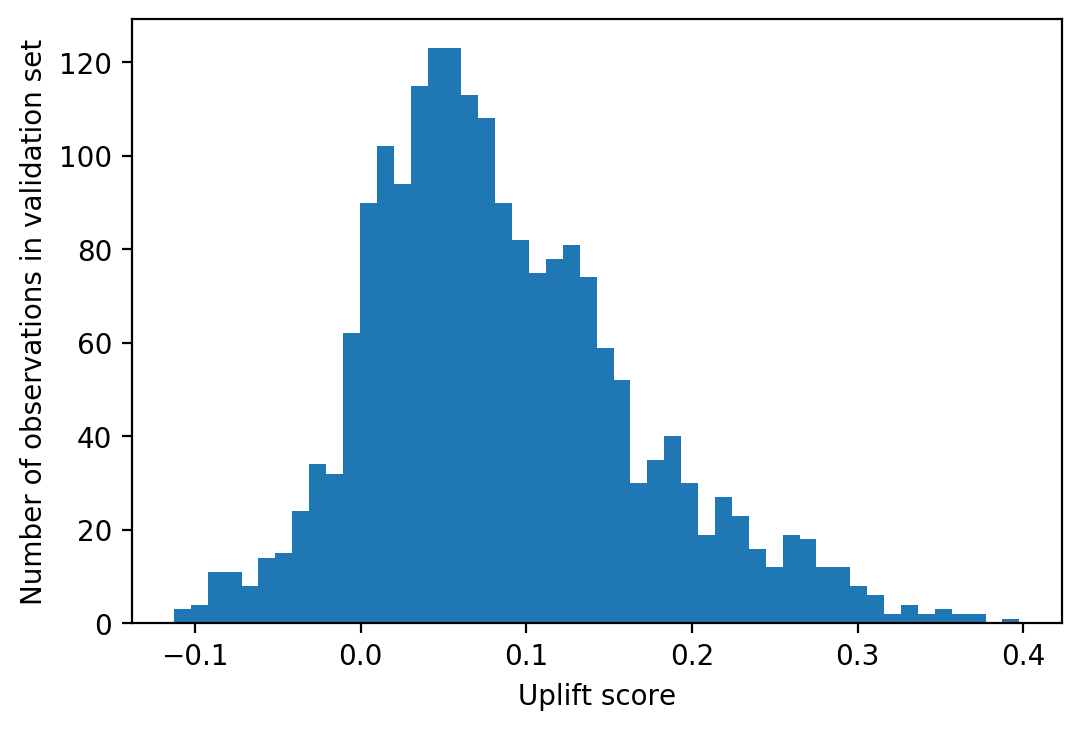

In [20]:
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['figure.figsize'] = (6,4)
plt.hist(Uplift, bins=50)
plt.xlabel('Uplift score')
plt.ylabel('Number of observations in validation set')

The distribution of uplift is mostly positive, which makes sense since we know from our analysis of the experiment that the treatment encourages conversion on average. However some instances have negative uplift, meaning treatment actually __discourages__ conversion for some people. In other words there appears to be a sleeping dog effect in these data.

The main questions now are: should we trust these results? How do we know how good this model is? Metrics for uplift model evaluation are more complex than typical metrics used in supervised learning, such as the ROC AUC for classification tasks or RMSE for regression. Generally speaking, uplift evaluation metrics make a comparison of the conversion rate between the treatment and control groups, for different ranges of the predicted uplift score. For those with high uplift scores, we'd expect to see a larger difference between treatment and control, while those with lower uplift scores should have a smaller difference, or even a larger conversion rate in the control group in the case of sleeping dogs (i.e. negative difference).

## Quantile metrics <a class="anchor" id="quantile-metrics"></a>
A popular way to evaluate an uplift model is with a quantile chart. This will give a quick visual impression of whether the model is "working", in the sense of sloping true uplift. To create the quantile chart, we start with the uplift predictions for our validation set, and bin the instances into quantiles based on these scores. The number of quantiles depends on how much data we have, although 10 is a pretty typical number in practice (deciles). Then, within each bin, we'll find the difference in conversion rate for those who were in the treatment group and those who were in the control group. If the model is working well, we should see a larger positive difference in the highest decile, decreasing to a small or negative difference in the lowest decile (i.e. treatment rate similar to control rate, or lower than control rate). In other words, as predicted uplift increases, the true uplift from control to treatment group should increase as well.

### Get score quantiles <a class="anchor" id="get-quantiles"></a>
Create a new `DataFrame` from the validation data, to add the uplift scores and quantiles.

In [21]:
Uplift.shape

(2000,)

In [22]:
valid.shape

(2000, 43)

In [23]:
valid_w_score = valid.copy()
valid_w_score['Uplift score'] = Uplift

In [24]:
valid_w_score.head()

,Unnamed: 0,trial_id,treatment_group_key,conversion,control_conversion_prob,treatment1_conversion_prob,treatment1_true_effect,x1_informative,x2_informative,x3_informative,...,x28_irrelevant,x29_irrelevant,x30_irrelevant,x31_uplift_increase,x32_uplift_increase,x33_uplift_increase,x34_uplift_increase,x35_uplift_increase,x36_uplift_increase,Uplift score
6252,6252,0,0,1,0.091233,0.043904,-0.047329,0.128796,0.582004,2.027088,...,0.971923,-1.332471,0.218589,0.700103,0.074845,0.580532,-1.966506,-0.322667,-1.311465,0.009574
4684,4684,0,1,0,0.101494,0.069031,-0.032464,-0.249103,-0.032255,0.030591,...,0.015858,-0.160939,0.211841,0.447512,-0.269382,-0.328579,-0.297928,-0.473154,-1.592787,-0.003638
1731,1731,0,1,0,0.408242,0.816324,0.408081,0.694069,-0.288068,-0.588280,...,0.190106,1.643789,1.558527,0.684027,0.367873,-0.744745,0.378264,0.532618,0.103382,0.288655
4742,4742,0,1,0,0.036061,0.055446,0.019384,-1.012592,0.239213,-0.402686,...,-0.491389,-0.947252,-0.185026,0.085944,-0.661352,-0.770008,0.860812,-0.749852,-0.391099,0.131196
4521,4521,0,0,1,0.206175,0.125444,-0.080731,-1.564519,-0.809688,0.859528,...,1.053866,1.378201,-0.370168,-0.690919,0.383968,0.745777,0.693021,-0.860461,1.262036,0.042706


Check that the treatment and control groups are approximately balanced, overall for the validation set (they should be since we used a random training/validation split but it's always good to check):

In [25]:
valid_w_score['treatment_group_key'].value_counts()

0    1011
1     989
Name: treatment_group_key, dtype: int64

Now, using the entire validation set (treatment and control groups together), make labels for the uplift score quantiles. We'll check that the treatment and control groups are balanced within the quantiles, since we'll be splitting the data by quantile and treatment to create the chart. Pandas has a convenient function to produce a series of labels according to which quantile an observation in the input series belongs to.

In [26]:
score_quantiles, score_quantile_bins = \
pd.qcut(x=valid_w_score['Uplift score'],
        q=10,
        retbins=True,
        duplicates='drop')

From this function we get a column indicating which quantile each instance belongs to, represented by the bin edges:

In [27]:
score_quantiles.head()

6252    (-0.00339, 0.0186]
4684    (-0.114, -0.00339]
1731        (0.201, 0.398]
4742        (0.121, 0.148]
4521      (0.0391, 0.0548]
Name: Uplift score, dtype: category
Categories (10, interval[float64]): [(-0.114, -0.00339] < (-0.00339, 0.0186] < (0.0186, 0.0391] < (0.0391, 0.0548] ... (0.0941, 0.121] < (0.121, 0.148] < (0.148, 0.201] < (0.201, 0.398]]

We also get a list of all bin edges in `score_quantile_bins`, but we don't need it here. Now let's add the score quantile to the dataframe so we can use it for analysis.

In [28]:
valid_w_score['Quantile bin'] = score_quantiles
valid_w_score[[
    'treatment_group_key', 'conversion', 'Uplift score', 'Quantile bin']].head(10)

,treatment_group_key,conversion,Uplift score,Quantile bin
6252,0,1,0.009574,"(-0.00339, 0.0186]"
4684,1,0,-0.003638,"(-0.114, -0.00339]"
1731,1,0,0.288655,"(0.201, 0.398]"
4742,1,0,0.131196,"(0.121, 0.148]"
4521,0,1,0.042706,"(0.0391, 0.0548]"
6340,0,1,0.113626,"(0.0941, 0.121]"
576,1,0,-0.018831,"(-0.114, -0.00339]"
5202,1,0,-0.036599,"(-0.114, -0.00339]"
6363,1,1,0.113048,"(0.0941, 0.121]"
439,0,1,0.074832,"(0.0726, 0.0941]"


Check that the number of treated and control observations within quantile bins are similar, using groupby/count and some multiindex magic:

In [29]:
count_by_quantile_and_treatment = valid_w_score.groupby(
    ['Quantile bin', 'treatment_group_key'])['treatment_group_key'].count()
count_by_quantile_and_treatment = count_by_quantile_and_treatment.unstack(-1)
count_by_quantile_and_treatment

treatment_group_key,0,1
Quantile bin,,
"(-0.114, -0.00339]",93,107
"(-0.00339, 0.0186]",110,90
"(0.0186, 0.0391]",99,101
"(0.0391, 0.0548]",105,95
"(0.0548, 0.0726]",112,88
"(0.0726, 0.0941]",100,100
"(0.0941, 0.121]",102,98
"(0.121, 0.148]",107,93
"(0.148, 0.201]",89,111


Text(0.5, 0, 'Number of observations')

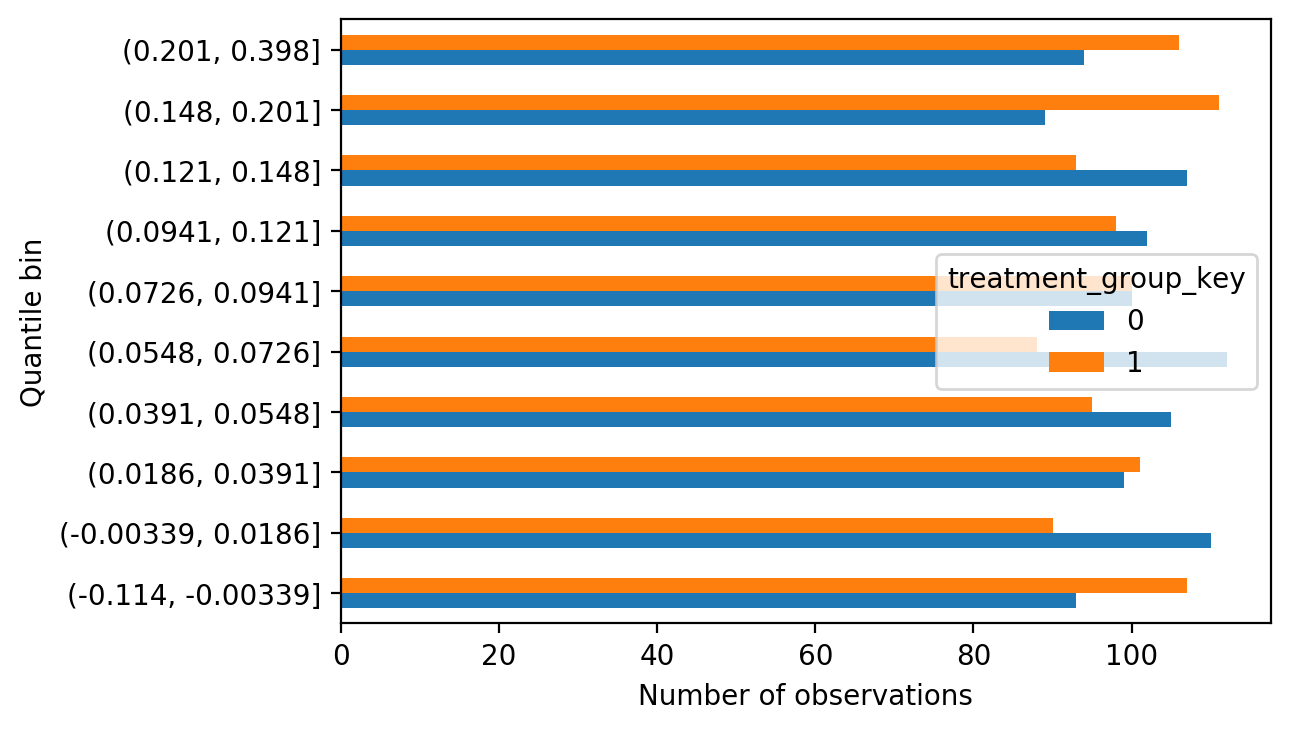

In [30]:
count_by_quantile_and_treatment.plot.barh()
plt.xlabel('Number of observations')

Without being too precise about it, it doesn't appear that the score quantiles are unbalanced in terms of the proportion of treatment and control; they are similar in each bin. This is expected, as we are working with data from a randomized experiment, however again it's good to check such assumptions.

### Uplift quantile chart <a class="anchor" id="quantile-chart"></a>

On to the uplift quantile chart. We'll start by creating a mask we can use for the treatment group:

In [31]:
validation_treatment_mask = valid_w_score['treatment_group_key'] == 1

Then we get the conversion rates within uplift score quantiles, separately for treatment and control groups:

In [32]:
treatment_by_quantile = valid_w_score[validation_treatment_mask]\
    .groupby('Quantile bin')['conversion'].mean()
control_by_quantile = valid_w_score[~validation_treatment_mask]\
    .groupby('Quantile bin')['conversion'].mean()

Finally we calculate their difference, which is the true uplift within each score quantile.

In [33]:
true_uplift_by_quantile = treatment_by_quantile - control_by_quantile
true_uplift_by_quantile.head(5)

Quantile bin
(-0.114, -0.00339]   -0.017486
(-0.00339, 0.0186]    0.034343
(0.0186, 0.0391]     -0.004600
(0.0391, 0.0548]      0.021554
(0.0548, 0.0726]      0.133929
Name: conversion, dtype: float64

Now we have all the information needed to plot an uplift quantile chart.

Text(0.5, 0, 'True uplift')

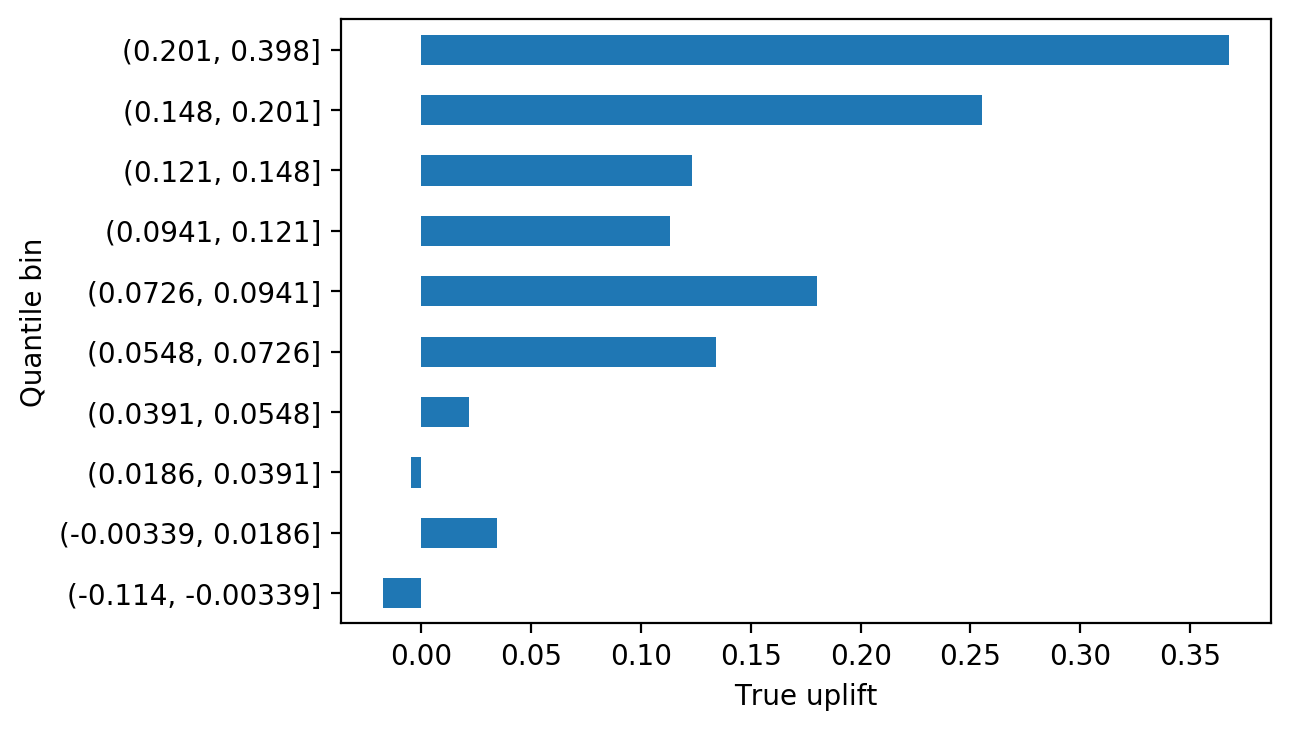

In [34]:
true_uplift_by_quantile.plot.barh()
plt.xlabel('True uplift')

The uplift quantile chart shows that, for the most part, true uplift increases from lower score bins to higher ones, which is what we'd expect to see if the model is working. So it appears our model can effectively segment out customers who more readily respond to treatment. In a real project, it would be important to repeat this analysis on a held-out test set, to confirm the model works with data that was not used at all for model training, since technically this validation set was used for early stopping in the model fitting process. However good performance on the validation set is a good sign and as long as the test set has similar characteristics to the training and validation sets, we'd expect to see similar performance there.

What can we learn from the quantile chart? From analysis of the experiment we know the ATE is about 10%. The quantile chart we created with the validation set tells us that by targeting the top decile of uplift scores, we may achieve a treatment effect of over 35%, a noticeable increase. The next few deciles appear to have larger treatment effects than the ATE as well. Depending on how expensive the treatment is to apply, it may make sense to target a limited portion of the population using this information.

We can also see that the sleeping dog effect has some support from observations of the true uplift. The bottom score decile, which consists entirely of negative scores, in fact has negative true uplift. So it appears that targeting the bottom 10% of the population, by uplift score, actually has a negative impact on the business.

### Calibration of uplift <a class="anchor" id="calibration"></a>

While the uplift quantile chart provides a qualitative snapshot telling us whether the model is effective at segmenting customers or not, we can go a step further in this direction and ask how accurate the model is at predicting uplift. This is the process of calibration, for which we'll need the average predicted uplift within the score quantiles:

In [35]:
predicted_uplift_by_quantile = valid_w_score\
    .groupby(['Quantile bin'])['Uplift score'].mean()
predicted_uplift_by_quantile.head(5)

Quantile bin
(-0.114, -0.00339]   -0.035133
(-0.00339, 0.0186]    0.008385
(0.0186, 0.0391]      0.029582
(0.0391, 0.0548]      0.047033
(0.0548, 0.0726]      0.063634
Name: Uplift score, dtype: float32

We'll put this together in a `DataFrame` with the true uplift that we calculated above, to create a scatter plot. If the uplift predictions are accurate, a scatter plot of predicted and true uplift should lie close to the one-one line.

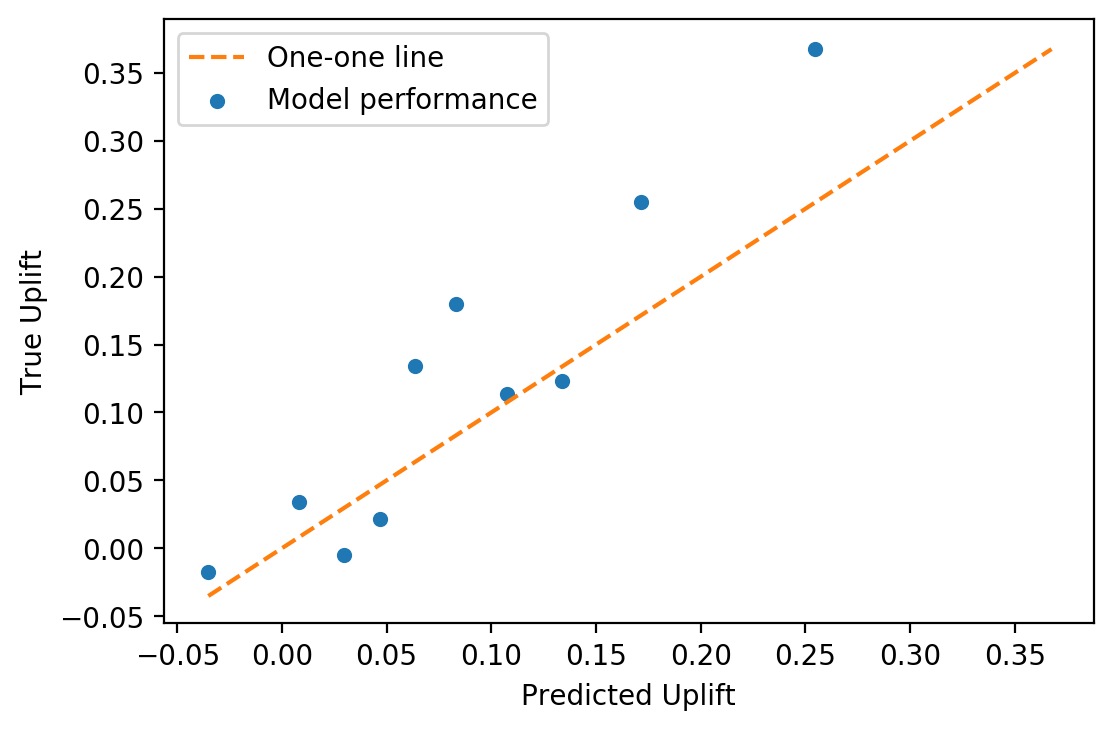

In [36]:
pred_true_uplift = pd.DataFrame({'Predicted Uplift':predicted_uplift_by_quantile,
                                 'True Uplift':true_uplift_by_quantile})

min_on_plot = pred_true_uplift.min().min()
max_on_plot = pred_true_uplift.max().max()

ax = plt.axes()
ax.plot([min_on_plot, max_on_plot], [min_on_plot, max_on_plot],
        linestyle='--', color='tab:orange', label='One-one line')
pred_true_uplift.plot.scatter(x='Predicted Uplift', y='True Uplift',
                              ax=ax, label='Model performance')

ax.legend()

Qualitatively, we can see from the calibration plot that mean predicted uplift is close to true uplift, by quantile. This calibration could be made more precise by calculating some sort of metric, perhaps MAE (mean absolute error), as a measure of model goodness of fit.

There are a few other ways these quantile-based analyses could be extended:
- The predictions for treatment = 1 and treatment = 0, that were used to calculate uplift, could be separately calibrated against the conversion rates by deciles of those scores, in the treatment and control groups respectively. This would be the calibration of predicted probability of conversion for these groups.
- Error bars could be included on all plots. For predicted probability of conversion, one could calculate the standard error of the mean within each bin of the treatment and control groups separately, while for true conversion rate one could use the normal approximation to the binomial. Then when subtracting the means of treatment and control to get uplift, the variances based on these calculations would be added, and the standard error of uplift could be calculated within each bin.
- In a business situation, the cost of treatment and the expected revenue of conversion should be known. The uplift quantile chart could be extended to represent uplift in revenue, which could be balanced against the cost of treatment to assess profitability of a business strategy.

## Cumulative metrics <a class="anchor" id="cumulative-metrics"></a>
### Cumulative gain chart <a class="anchor" id="Cumulative-gain"></a>
When using uplift scores in practice, a common approach is to rank customers in descending order, according to their uplift score. We can extend the quantile chart idea to calculate how many additional customers ("incremental customers") we can obtain by targeting a particular fraction of the population, in this way.

This idea underlies the cumulative gain chart. The formula for cumulative gain is given by Gutierrez and Gerardy (2016) as:

$$ \left( \frac{Y^T}{N^T} - \frac{Y^C}{N^C} \right) \left( N^T + N^C \right)$$

where $Y^T$ is the cumulative sum of conversions in each bin of the treatment group, starting with the highest score bin and proceeding down, and $N^T$ is the cumulative number of customers found in the same way; $Y^C$ and $N^C$ are similar cumulative sums for the control group. Cumulative gain effectively measures the cumulative uplift in probability of conversion, starting with the highest bin, and multiplies by the number of total customers in both treatment and control groups, to estimate the number of additional conversions that would occur if that number of customers were targeted.

To get the data for the cumulative gain chart, we will need to calculate the amount of customers in each score quantile bin, both in the treatment and control groups (we visualized this above but will recalculate it here) and also the sum of converted customers. Here we'll flip the result upside down with `.iloc[::-1]` to simulate the strategy of targeting the customers with highest uplift scores first, and proceeding down from there.

In [37]:
treatment_count_by_quantile = valid_w_score[validation_treatment_mask]\
    .groupby('Quantile bin').agg({'conversion':['sum', 'count']}).iloc[::-1]

control_count_by_quantile = valid_w_score[~validation_treatment_mask]\
    .groupby('Quantile bin').agg({'conversion':['sum', 'count']}).iloc[::-1]

Here is how the treatment group looks, for example:

In [38]:
treatment_count_by_quantile.head(5)

conversion      
                        sum count
Quantile bin                     
(0.201, 0.398]           57   106
(0.148, 0.201]           57   111
(0.121, 0.148]           41    93
(0.0941, 0.121]          38    98
(0.0726, 0.0941]         37   100

And the cumulative sums of conversions and total customers:

In [39]:
treatment_count_by_quantile.cumsum().head(5)

conversion      
                        sum count
Quantile bin                     
(0.201, 0.398]           57   106
(0.148, 0.201]          114   217
(0.121, 0.148]          155   310
(0.0941, 0.121]         193   408
(0.0726, 0.0941]        230   508

Putting all this together into the formula for cumulative gain shown above, we have:

In [40]:
cumulative_gain = \
    ((treatment_count_by_quantile[('conversion','sum')].cumsum()
      / treatment_count_by_quantile[('conversion','count')].cumsum())
     -
     (control_count_by_quantile[('conversion','sum')].cumsum()
      / control_count_by_quantile[('conversion','count')].cumsum())) \
    * (treatment_count_by_quantile[('conversion','count')].cumsum()
       + control_count_by_quantile[('conversion','count')].cumsum())

We can now examine and plot the cumulative gain.

In [41]:
cumulative_gain.round()

Quantile bin
(0.201, 0.398]         74.0
(0.148, 0.201]        125.0
(0.121, 0.148]        149.0
(0.0941, 0.121]       172.0
(0.0726, 0.0941]      209.0
(0.0548, 0.0726]      237.0
(0.0391, 0.0548]      242.0
(0.0186, 0.0391]      240.0
(-0.00339, 0.0186]    249.0
(-0.114, -0.00339]    248.0
dtype: float64

Text(0.5, 0, 'Cumulative gain in converted customers')

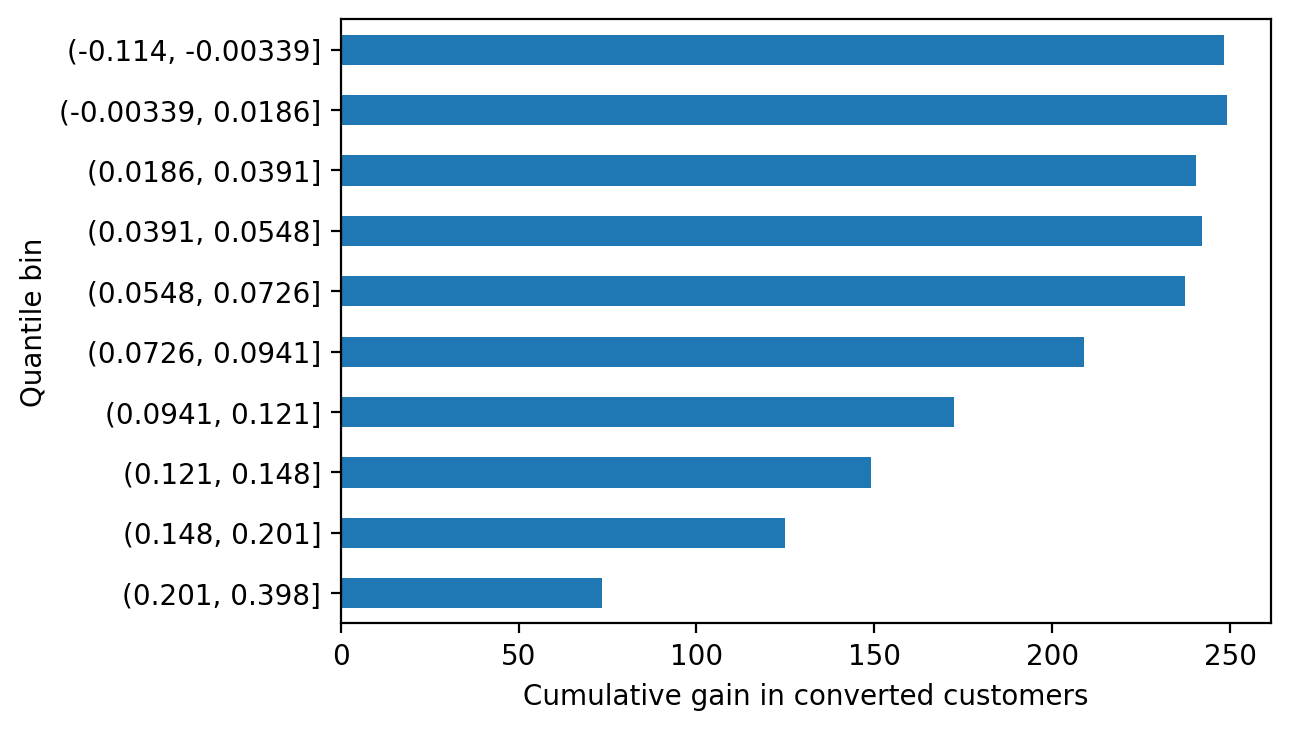

In [42]:
cumulative_gain.plot.barh()
plt.xlabel('Cumulative gain in converted customers')

Cumulative gain gives another way to look at the potential impact of an uplift model-guided strategy. If we offer the treatment to every customer, we'll increase the number of converted customers by 248. However we can achieve a gain of 149 customers, about 60% of the maximum possible, by only offering treatment to the top 30% of customers (top 3 deciles), by uplift score. This is because as we move down the list, we're targeting customers with lower predicted individual treatment effect. The cumulative number of conversions may even go down from bin to bin, in the lower-valued bins of the chart, as we actually lose customers by targeting sleeping dogs.

### Cumulative gain curve <a class="anchor" id="gain-curve"></a>
The various charts above are all informative and intuitive ways to understand the performance of an uplift model, however they don't immediately lead to model performance metrics, by which different modeling approaches might be compared. In order to make this leap, the idea of cumulative gain can be generalized to a curve, in a similar way to how the receiver operating characteristic (ROC) curve is used to evaluate binary classifiers. To get an ROC curve, true positive rates and false positive rates are calculated as the threshold for positive classification is successively raised to include more and more instances in a data set, until all are included. By comparison, a cumulative gain curve measures the cumulative gain in conversions, as defined above, in the targeted population as more and more people are targeted according to descending uplift score, until all are targeted.

The gain curve is defined as

$$ f(t) = \left( \frac{Y_t^T}{N_t^T} - \frac{Y_t^C}{N_t^C} \right) \left( N_t^T + N_t^C \right)$$

where $t$ is the index of the customer, starting from the highest uplift score and proceeding down, and the other variables are defined similarly to the previous equation.

The gain curve calculation is available as part of the CausalML package, where it is called the uplift curve (CausalML). It can also be calculated fairly quickly in pandas. The first step is sorting on uplift score:

In [43]:
sorted_valid = valid_w_score.sort_values('Uplift score', ascending=False)\
.reset_index(drop=True)

sorted_valid[['treatment_group_key', 'conversion', 'Uplift score']].head(10)

,treatment_group_key,conversion,Uplift score
0,1,0,0.397679
1,0,0,0.375838
2,0,0,0.372153
3,1,1,0.364114
4,1,1,0.361814
5,0,0,0.356630
6,0,0,0.349603
7,1,1,0.348355
8,0,1,0.345382
9,0,0,0.340867


On to this `DataFrame`, we add a few columns which will make the calculation of the curve easier, following the notation in the equations above.

In [44]:
sorted_valid['Y_T'] = \
    (sorted_valid['conversion'] * sorted_valid['treatment_group_key']).cumsum()
sorted_valid['Y_C'] = \
    (sorted_valid['conversion'] * (sorted_valid['treatment_group_key']==0)).cumsum()
sorted_valid['N_T'] = sorted_valid['treatment_group_key'].cumsum()
sorted_valid['N_C'] = (sorted_valid['treatment_group_key']==0).cumsum()

In [45]:
sorted_valid[['treatment_group_key', 'conversion', 'Uplift score',
              'Y_T', 'Y_C', 'N_T', 'N_C']].head(10)

,treatment_group_key,conversion,Uplift score,Y_T,Y_C,N_T,N_C
0,1,0,0.397679,0,0,1,0
1,0,0,0.375838,0,0,1,1
2,0,0,0.372153,0,0,1,2
3,1,1,0.364114,1,0,2,2
4,1,1,0.361814,2,0,3,2
5,0,0,0.356630,2,0,3,3
6,0,0,0.349603,2,0,3,4
7,1,1,0.348355,3,0,4,4
8,0,1,0.345382,3,1,4,5
9,0,0,0.340867,3,1,4,6


Now the calculation of the gain curve can be done as follows:

In [46]:
sorted_valid['Gain curve'] = (
    (sorted_valid['Y_T']/sorted_valid['N_T'])
    -
    (sorted_valid['Y_C']/sorted_valid['N_C'])
    ) * (sorted_valid['N_T'] + sorted_valid['N_C'])

Let's examine the gain curve.

Text(0, 0.5, 'Gain in conversion')

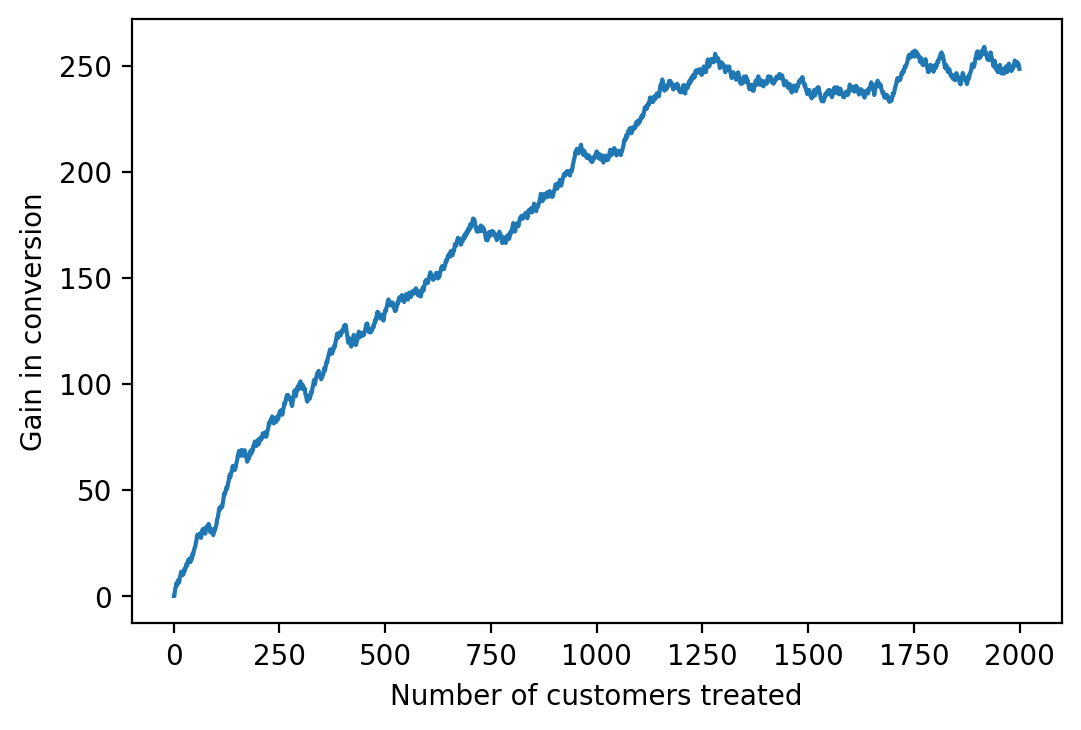

In [47]:
sorted_valid['Gain curve'].plot()
plt.xlabel('Number of customers treated')
plt.ylabel('Gain in conversion')

The gain curve looks fairly similar to how the gain chart above would look (if it were turned on its side), just more continuous, and largely tells the same story. One advantage of the curve, however, is that similar to the ROC curve, we can calculate an area under the curve, with the interpretation that larger areas mean a more performant model: we would like to be able to gain as many customers as possible, by targeting a few as possible. If we had perfect knowledge of who would respond positively to treatment, we would treat only those who would, and the gain curve as plotted above would have a slope of one initially, before leveling off and potentially declining if there were sleeping dogs. This would lead to a gain curve with a steep initial slope, that stayed high as long as possible, resulting in a large area under the curve.

Before calculating an AUC, it can be beneficial to normalize the data. As shown, the gain curve has units of customers on both the x- and y-axes. This can be good for visualizing things in terms of real-world quantities. However, if we wanted to assess performance on validation and test sets, for example, the areas under these curves may not be comparable as these datasets may have different numbers of observations. We can remedy this by scaling the curve so that both the x- and y-axes have a maximum of 1.

The scaled x-axis represents the fraction of the population targeted:

In [48]:
gain_x = sorted_valid.index.values + 1
gain_x = gain_x/gain_x.max()
print(gain_x[:3])
print(gain_x[-3:])

[0.0005 0.001  0.0015]
[0.999  0.9995 1.    ]


And the scaled y-axis is the fraction of gain from treating the entire population:

In [49]:
gain_y = (
    sorted_valid['Gain curve']
    /
    sorted_valid['Gain curve'].tail(1).values
    ).values

print(gain_y[:3])
print(gain_y[-3:])

[nan  0.  0.]
[1.00802087 1.00534686 1.        ]


Note the first entry in the normalized gain curve is `NaN`; there will always be at least one of these at the beginning because either $N^T_t$ or $N^C_t$ will be zero for at least the first observation, leading to a divide by zero error. So we'll drop entries from both the x and y vectors here to get rid of `NaN`s, which shouldn't be an issue if the data set is large enough.

In [50]:
nan_mask = np.isnan(gain_y)
gain_x = gain_x[~nan_mask]
gain_y = gain_y[~nan_mask]
print(gain_y[:3])
print(gain_y[-3:])

[0.         0.         0.00805023]
[1.00802087 1.00534686 1.        ]


Now we can plot the normalized gain curve, along with a computed AUC. To this, we'll add a one-one line. Similar to the interpretation of a one-one line on an ROC curve, here this corresponds to the gain curve we'd theoretically expect by treating customers at random: the fraction of the gain we would get by treating all customers increases according to the fraction treated and the ATE.

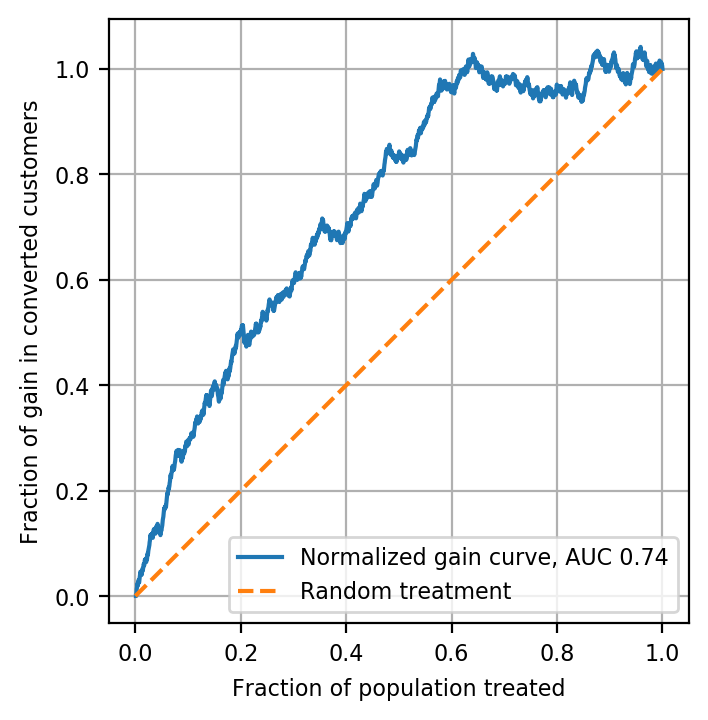

In [51]:
mpl.rcParams['font.size'] = 8
gain_auc = auc(gain_x, gain_y)

ax = plt.axes()
ax.plot(gain_x, gain_y,
        label='Normalized gain curve, AUC {}'.format(gain_auc.round(2)))
ax.plot([0, 1], [0, 1],
        '--', color='tab:orange',
        label='Random treatment')
ax.set_aspect('equal')
ax.legend()
ax.set_xlabel('Fraction of population treated')
ax.set_ylabel('Fraction of gain in converted customers')
ax.grid()

Notice that, unlike an ROC curve, the gain curve can actually exceed 1.0 on the y-axis. This is because we may be able to gain more customers than the number we'd get by treating everyone, if we can avoid some sleeping dogs.

The AUC calculated here gives a general way to compare uplift model performance across different models and data sets, such as the training, validation, and testing sets for a given application. Normalized gain curves can be plotted together and have their AUCs compared in the same way ROC AUCs are compared for supervised classification problems. The interested reader may wish to develop a T-Learner model and compare with the S-Learner results shown here as an exercise.

As a final step here we'll save the validation set and the trained model, in case we want to do further analysis.

In [52]:
# with open('data/validation_set_and_model_7_8_20.pkl', 'wb') as fname:
#     pickle.dump([valid_w_score, model], fname)

# Conclusion <a class="anchor" id="conclusion"></a>
The goal of uplift modeling is to create predictive models of the individual treatment effect. Such models allow data scientists to segment populations into groups that are more likely to respond to treatment, and those that are less so. With this goal, a variety of modeling techniques have been developed; uplift modeling continues to receive active research interest. The evaluation of uplift models is not as straightforward as that of supervised classification or regression models because it requires separate consideration, and comparison, of treatment and control groups. However, open source Python packages (CausalML, Pylift) have been created to facilitate uplift model development and evaluation. Several useful uplift evaluation techniques, some of which are available in those packages, were demonstrated here using Python and pandas.

---

Thanks to Pierre Gutierrez and Robert Yi for your input and feedback

# References <a class="anchor" id="references"></a>

[CausalML: a Python package that provides a suite of uplift modeling and causal inference methods using machine learning algorithms based on recent research. Accessed 7/5/2020.](https://causalml.readthedocs.io/en/latest/about.html)

[Gutierrez, Pierre and Jean-Yves Gerardy, 2016. Causal Inference and Uplift Modeling: A review of the literature. JMLR: Workshop and Conference Proceedings 67:1-13.](http://proceedings.mlr.press/v67/gutierrez17a/gutierrez17a.pdf)

[Kunzel, Soren R. et al., 2019. Metalearners for estimating heterogeneous treatment effects using maching learning. PNAS March 5, 2019 115 (10) 4156-4165](https://www.pnas.org/content/116/10/4156)

[Lee, Taiyeong et al., 2013 Incremental Response Modeling Using SAS Enterprise Miner. SAS Global Forum 2013: Data Mining and Text Analytics.](https://support.sas.com/resources/papers/proceedings13/096-2013.pdf)

[Pylift: an uplift library that provides, primarily, (1) fast uplift modeling implementations and (2) evaluation tools. Accessed 7/5/2020.](https://pylift.readthedocs.io/en/latest/)

[Yi, Robert and Will Frost, 2018. Pylift: A Fast Python Package for Uplift Modeling. Accessed 7/5/2020.](https://tech.wayfair.com/data-science/2018/10/pylift-a-fast-python-package-for-uplift-modeling)

[Zhao, Zhenyu et al., 2020. Feature Selection Methods for Uplift Modeling.](https://arxiv.org/abs/2005.03447)